In [40]:
import pandas as pd
from tqdm import tqdm
from database.strategy import Strategy
from database.market import Market
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
import numpy as np
import statistics
from sklearn.preprocessing import normalize

In [41]:
strat_db = Strategy("unity")
market = Market()
suffix = "tsmc_full"

In [42]:
market.connect()
sp5 = market.retrieve_data("sp500")
market.close()

In [43]:
strat_db.connect()
tse = strat_db.retrieve_data("{}_epochs".format(suffix))
strat_db.close()
bench = pd.read_csv("GSPC.csv")

In [44]:
list(tse.columns)

['_id', 'epoch', 'score', 'ascending', 'wdr', 'pf']

In [45]:
strat_db.connect()
analysis = []
start = datetime(2018,1,1)
end = datetime(2021,1,1)
seats = 4
cash = 100
for epoch in tqdm(tse["epoch"].unique()):
    epoch_dict = tse[tse["epoch"]==epoch].iloc[0]
    trades = strat_db.retrieve_data("{}_{}".format(suffix,epoch))
    trades = trades[(trades["date"]>=start) & (trades["sell_date"] <= end)]
    if trades.index.size < 1:
        print(epoch,trades.index.size)
        continue
    else:
        index = 0
        captured_seats = 0
        while captured_seats <= seats or index <= 20:
            initial = float(cash/(seats + 1))
            seat_trades = trades[trades["seat"] == index]
            seat_trades.sort_values("sell_date",inplace=True)
            if index > 20:
                break
            if captured_seats > seats:
                break
            if seat_trades.index.size > 0:
                for delta in seat_trades["sell_delta"]:
                    initial = initial * (1 + delta)
                stg = seat_trades.groupby("seat").mean().reset_index()[["adjclose","sell_price","seat","sell_delta"]]
                for col in list(tse.columns):
                    if col == "__id":
                        continue
                    else:
                        stg[col] = epoch_dict[col]
#                 stg["pv"] = seat_trades.tail(1)["pv"].item()
                stg["initial_pv"] = initial
                stg["trades"] = seat_trades.index.size
                stg["seat"] = captured_seats
                stg["winrate"] = seat_trades[seat_trades["sell_delta"] > 0].index.size / seat_trades.index.size
                initial = float(cash/(seats + 1))
                analysis.append(stg)
                index += 1
                captured_seats += 1
                continue
            else:
                index += 1
                continue
strat_db.close()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.89it/s]


In [46]:
a = pd.concat(analysis)

In [47]:
metric = "initial_pv"
index_cols = list(tse.columns)
index_cols.remove("_id")
tsmc = ""
apt = a.pivot_table(index=index_cols,columns="seat",values=metric)
if metric == "winrate":
    apt[metric] = [statistics.mean([row[1][i] for i in range(seats) if not np.isnan(row[1][i])]) for row in apt.iterrows()]
else:
    apt.fillna(cash/(seats+1),inplace=True)
    apt[metric] = [sum([row[1][i] for i in range(seats+1) if i in apt.columns]) for row in apt.iterrows()]
    apt["perf"] = 1 + (apt[metric] - cash) / cash
apt.reset_index(inplace=True)

In [48]:
apt.sort_values(metric,ascending=False).head(50)

seat,epoch,score,ascending,wdr,pf,0,1,2,3,4,initial_pv,perf
1,1,0.7,False,0,True,5008.253611,1285.931381,1702.107078,904.171494,2227.705259,11128.168823,111.281688
3,3,0.7,False,5,True,3543.567435,2318.564698,2273.551520,627.775249,1517.716904,10281.175807,102.811758
5,5,0.7,False,10,True,1197.750531,3377.408460,1371.303566,652.681425,480.501511,7079.645492,70.796455
15,15,0.7,False,5,False,1387.464978,657.680958,1416.141007,1470.322120,1702.453227,6634.062289,66.340623
13,13,0.7,False,0,False,1139.092177,1241.309779,1320.899029,1827.967926,653.346041,6182.614952,61.826150
2,2,0.7,True,5,True,516.717331,2134.949396,612.080924,1108.838848,531.344364,4903.930864,49.039309
9,9,0.8,False,5,True,1367.022440,986.689752,966.030137,591.316203,644.766803,4555.825335,45.558253
7,7,0.8,False,0,True,1188.130261,1026.286558,752.438987,620.495246,645.473312,4232.824364,42.328244
17,17,0.7,False,10,False,911.527819,683.944231,1345.537784,423.557432,838.139391,4202.706658,42.027067
4,4,0.7,True,10,True,639.926258,1155.929882,899.896983,944.029605,522.013441,4161.796169,41.617962


In [49]:
if tsmc == "industry":
    bf = []
    for industry in apt["industry"].unique():
        industry_apt = apt[apt["industry"] == industry].sort_values(metric,ascending=False).head(1)
        bf.append(industry_apt)
    bff = pd.concat(bf)
    bff.sort_values(metric,ascending=False)

In [50]:
strat_db.connect()
epoch = apt.sort_values(metric,ascending=False).reset_index().iloc[0]["epoch"]
analysis = []
trades = strat_db.retrieve_data("{}_{}".format(suffix,int(epoch)))
trades = trades[(trades["date"]>=start) & (trades["sell_date"] <= end)]
strat_db.close()

In [51]:
print("trades:",len(trades))
top_epoch = tse[tse["epoch"]==epoch]
for col in top_epoch.columns:
    print(col,":",top_epoch[col].item())

trades: 1436
_id : 5fafe0a1d3cb6863bf6af55b
epoch : 1
score : 0.7
ascending : False
wdr : 0
pf : True


In [52]:
trades.sort_values("date")
trades["date"] = pd.to_datetime(trades["date"])
trades["sell_date"] = pd.to_datetime(trades["sell_date"])
dta = "date"
trades["week"] = [x.week for x in trades[dta]]
trades["quarter"] = [x.quarter for x in trades[dta]]
trades["dayofWeek"] = [x.weekday() for x in trades[dta]]
trades["month"] = [x.month for x in trades[dta]]
trades["year"] = [x.year for x in trades[dta]]
trades = trades[trades["sell_date"] <= end]

In [53]:
bench

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-04,1994.010010,2009.130005,1986.770020,1999.989990,1999.989990,6049930000
1,2016-03-07,1996.109985,2006.119995,1989.380005,2001.760010,2001.760010,4968180000
2,2016-03-08,1996.880005,1996.880005,1977.430054,1979.260010,1979.260010,4641650000
3,2016-03-09,1981.439941,1992.689941,1979.839966,1989.260010,1989.260010,4038120000
4,2016-03-10,1990.969971,2005.079956,1969.250000,1989.569946,1989.569946,4376790000
...,...,...,...,...,...,...,...
1253,2021-02-25,3915.800049,3925.020020,3814.040039,3829.340088,3829.340088,6513060000
1254,2021-02-26,3839.659912,3861.080078,3789.540039,3811.149902,3811.149902,6512950000
1255,2021-03-01,3842.510010,3914.500000,3842.510010,3901.820068,3901.820068,5071540000
1256,2021-03-02,3903.639893,3906.409912,3868.570068,3870.290039,3870.290039,5493690000


In [54]:
prices = trades
daily = prices.groupby(["year","dayofWeek"]).mean().reset_index()
quarterly = prices.groupby(["year","quarter"]).mean().reset_index()
monthly = prices.groupby(["year","month"]).mean().reset_index()
weekly = prices.groupby(["year","week"]).mean().reset_index()

In [55]:
trades

,_id,date,ticker,adjclose,weekly_price_regression_prediction,weekly_price_regression_prediction_delta,weekly_price_regression_score,trade_signal_classification_prediction,trade_signal_classification_score,week,...,category,rolling_performance,predicted_delta,sell_price,sell_date,sell_delta,seat,quarter,dayofWeek,month
128,5faef290e5eb5fa537d8c206,2018-01-08,TPR,41.613840,50.756714,0.219708,0.842804,1,0.900000,2,...,0.0,0.012620,0.206653,42.064067,2018-01-12,0.010819,1,1,0,1
129,5faef38fe5eb5fa537d8c76f,2018-01-16,MOS,25.143304,27.436417,0.091202,0.967167,1,0.705882,3,...,0.0,0.017979,-0.132705,26.729447,2018-01-23,0.063084,1,1,1,1
130,5faef528e5eb5fa537d8d146,2018-01-24,ULTA,224.310000,246.892761,0.100677,0.988160,1,0.764706,4,...,1.0,0.008010,-0.021443,229.150000,2018-01-29,0.021577,1,1,2,1
131,5faef687e5eb5fa537d8da32,2018-01-30,WYNN,161.268256,195.419907,0.211769,0.976820,1,0.764706,5,...,0.0,0.012766,0.218166,160.421407,2018-02-01,-0.005251,1,1,1,1
132,5faef687e5eb5fa537d8da35,2018-02-02,WYNN,156.723500,195.419907,0.246909,0.976820,1,0.764706,5,...,0.0,0.012766,-0.197962,166.848049,2018-02-07,0.064601,1,1,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2746,5fafb47be5eb5fa537dcabe9,2020-10-12,VFC,77.870000,72.026855,-0.075037,0.856466,0,0.808511,42,...,1.0,0.021604,0.073490,77.740000,2020-10-15,-0.001669,10,4,0,10
2747,5fafb356e5eb5fa537dca468,2020-10-16,AMD,83.170000,85.865173,0.032406,0.944911,1,0.914894,42,...,0.0,0.029996,0.016132,82.000000,2020-10-19,-0.014068,10,4,4,10
2748,5fafb53ee5eb5fa537dcb0f9,2020-10-20,KLAC,205.720000,228.021973,0.108409,0.883999,1,0.765957,43,...,0.0,0.009733,0.105293,206.300000,2020-10-21,0.002819,10,4,1,10
2749,5fafb4a3e5eb5fa537dcacfa,2020-10-22,AMZN,3176.400000,3477.918457,0.094925,0.984994,1,0.744681,43,...,1.0,0.021560,0.064674,3286.330000,2020-10-27,0.034608,10,4,3,10


In [56]:
timelines= []
cs = 0
index = 0
index = 0
print(seats)
while cs <= seats or index <= 20:
    timeline = []
    initial = float(cash/(seats + 1))
    st = prices[prices["seat"] == index]
    st.sort_values("sell_date",inplace=True)
    if index > 20:
        break
    if cs > seats:
        break
    if st.index.size > 0:
        for row in st.iterrows():
#             for day in range((row[1]["sell_date"] - row[1]["date"]).days):
#                 timeline.append({"date":row[1]["date"] + timedelta(days=day),"seat":cs,"pv":initial})
            initial = initial * (1 + row[1]["sell_delta"])
            timeline.append({"date":row[1]["sell_date"],"seat":cs,"pv":initial})
        timelines.append(pd.DataFrame(timeline))
        initial = float(100/(seats + 1))
        index+=1
        cs+=1
        continue
    else:
        index += 1
        continue
ts = pd.concat(timelines)

4


In [57]:
tspivot = ts.pivot_table(index="date",columns="seat",values="pv")
tspivot.iloc[0].fillna(100/(seats+1),inplace=True)

In [58]:
cleaned = []
for i in range(tspivot.index.size):
    row = tspivot.iloc[i]
    for col in tspivot.columns:
        if col == "date":
            continue
        else:
            col_val = row[col].item()
            if math.isnan(col_val):
                row[col] = tspivot.iloc[i-1][col].item()
            else:
                continue
    cleaned.append(row)

In [59]:
tspivot = pd.DataFrame(cleaned)

In [60]:
for i in range(seats+1):
    if i not in tspivot.columns:
        tspivot[i] = 100/(seats +1)

In [61]:
# tspivot = ts.pivot_table(index="date",columns="seat",values="pv")
tspivot["pv"] = [sum([row[1][i] for i in range(seats+1) if i in tspivot.columns]) for row in tspivot.iterrows()]
tspivot.reset_index(inplace=True)

In [62]:
tspivot

seat,index,0,1,2,3,4,pv
0,2018-01-11,20.000000,20.000000,20.000000,20.000000,20.006085,100.006085
1,2018-01-12,20.216383,20.399261,20.808016,20.946021,20.006085,102.375765
2,2018-01-17,20.216383,20.399261,20.808016,20.946021,19.958818,102.328498
3,2018-01-19,20.216383,21.596053,20.808016,20.946021,19.958818,103.525291
4,2018-01-23,21.491716,21.596053,21.187812,21.782785,20.622665,106.681031
...,...,...,...,...,...,...,...
371,2020-10-22,4560.767974,1274.009683,1521.441677,909.633684,2191.467788,10457.320806
372,2020-10-23,4998.781556,1283.180253,1588.147528,909.633684,2246.194344,11025.937365
373,2020-10-27,4916.834318,1267.607677,1602.551010,909.633684,2209.475668,10906.102356
374,2020-10-29,5008.253611,1285.931381,1602.551010,904.171494,2209.475668,11010.383164


In [63]:
pvs = [100]
current_pv = 100
for i in range(1,tspivot.index.size):
    replacement = current_pv/seats
    current_date = tspivot.iloc[i].fillna(replacement)
    current_pv =sum([current_date[c] for c in range(seats+1) if c in tspivot.columns])
    pvs.append(current_pv)
tspivot["pv"] = pvs 

In [64]:
bench.rename(columns={"Date":"index","Adj Close":"bench"},inplace=True)
bench["index"]= pd.to_datetime(bench["index"])
bench = bench[(bench["index"]>=start) & (bench["index"]<=end)]
bench["bench"] = (bench["bench"] - bench["bench"].iloc[0]) / bench["bench"].iloc[0]
tspivot["pv"] = (tspivot["pv"] - 100) / 100

In [65]:
tspivot = tspivot.merge(bench,on="index",how="left")

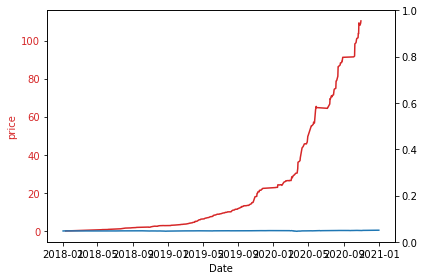

<Figure size 2304x1296 with 0 Axes>

In [66]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('price', color=color)
ax1.plot(tspivot["index"], tspivot["pv"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
# ax2.set_ylabel('bench', color=color)  # we already handled the x-label with ax1
ax1.plot(bench["index"],bench["bench"], color=color)
# ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.figure(figsize=(32,18))
fig.tight_layout()

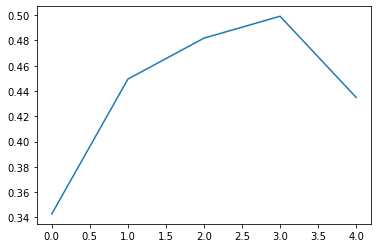

In [67]:
normalized = []
for year in daily["year"].unique():
    subset = daily[daily["year"] == year]
    subset["sell_delta"] = normalize([subset["sell_delta"]])[0]
    normalized.append(subset)
grouped = pd.concat(normalized).groupby("dayofWeek").mean().reset_index()
plt.plot(grouped["sell_delta"])

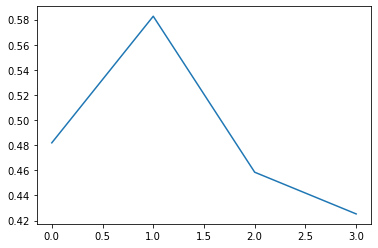

In [68]:
normalized = []
for year in quarterly["year"].unique():
    try:
        subset = quarterly[quarterly["year"] == year]
        subset["sell_delta"] = normalize([subset["sell_delta"]])[0]
        normalized.append(subset)
    except:
        continue
grouped = pd.concat(normalized).groupby("quarter").mean().reset_index()
plt.plot(grouped["sell_delta"])

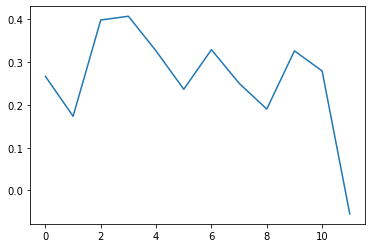

In [69]:
normalized = []
for year in monthly["year"].unique():
    try:
        subset = monthly[monthly["year"] == year]
        subset["sell_delta"] = normalize([subset["sell_delta"]])[0]
        normalized.append(subset)
    except:
        continue
grouped = pd.concat(normalized).groupby("month").mean().reset_index()
plt.plot(grouped["sell_delta"])

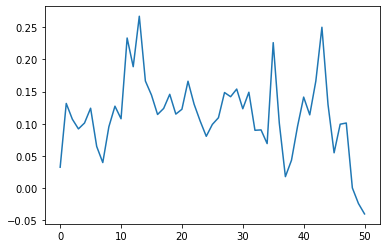

In [70]:
normalized = []
for year in weekly["year"].unique():
    try:
        subset = weekly[weekly["year"] == year]
        subset["sell_delta"] = normalize([subset["sell_delta"]])[0]
        normalized.append(subset)
    except:
        continue
grouped = pd.concat(normalized).groupby("week").mean().reset_index()
plt.plot(grouped["sell_delta"])

In [71]:
ntrades = []
trades.sort_values("date",inplace=True)
for year in trades["year"].unique():
    subset = trades[(trades["year"] == year)]
    for week in subset["week"].unique():
        ntrades.append(len(subset[(subset["week"] == week)]))
weekly["ntrades"]= ntrades

In [72]:
sp5.columns

Index(['_id', 'Symbol', 'Security', 'SEC filings', 'GICS Sector',
       'GICS Sub-Industry', 'Headquarters Location', 'Date first added', 'CIK',
       'Founded'],
      dtype='object')

In [73]:
trades["trade"] = 1

In [74]:
sp5["ticker"] = sp5["Symbol"]

In [75]:
ticker_yearly = trades.groupby(["year","ticker"]).sum().reset_index().merge(sp5, on="ticker",how="left")
yp = []
for year in ticker_yearly["year"].unique():
    yp.append(ticker_yearly[ticker_yearly["year"] == year].sort_values("sell_delta",ascending=False))
yp_final = pd.concat(yp)
yp_final["aggregate_gain"] = [(1+(row[1]["sell_delta"] / row[1]["trade"])) ** row[1]["trade"] - 1 for row in yp_final.iterrows()]
yp_final.sort_values("aggregate_gain",ascending=False)[["year","Security","ticker","GICS Sector","sell_delta","trade","aggregate_gain"]].head(50)

,year,Security,ticker,GICS Sector,sell_delta,trade,aggregate_gain
79,2018,DexCom,DXCM,Health Care,0.804399,7,1.141361
522,2020,DexCom,DXCM,Health Care,0.782102,8,1.108959
562,2020,L Brands Inc.,LB,Consumer Discretionary,0.666277,8,0.896447
437,2019,Tiffany & Co.,TIF,Consumer Discretionary,0.518047,5,0.637107
258,2019,Align Technology,ALGN,Health Care,0.518296,4,0.628017
263,2019,Advanced Micro Devices Inc,AMD,Information Technology,0.504424,7,0.627553
162,2018,NortonLifeLock,NLOK,Information Technology,0.492719,2,0.553412
477,2020,Align Technology,ALGN,Health Care,0.440300,4,0.518481
574,2020,Moody's Corp,MCO,Financials,0.448931,2,0.499316
150,2018,Marathon Oil Corp.,MRO,Energy,0.391823,11,0.469623


In [76]:
ticker_analysis = trades.groupby("ticker").sum().reset_index().merge(sp5, on="ticker",how="left")
ticker_analysis["aggregate_gain"] = [(1+(row[1]["sell_delta"] / row[1]["trade"])) ** row[1]["trade"] - 1 for row in ticker_analysis.iterrows()]
ticker_analysis["average_gain"] = [(row[1]["sell_delta"] / row[1]["trade"]) for row in ticker_analysis.iterrows()]
ticker_analysis.sort_values("aggregate_gain",ascending=False)[["Security","ticker","sell_delta","trade","average_gain"]].head(50)

,Security,ticker,sell_delta,trade,average_gain
106,DexCom,DXCM,1.760815,19,0.092674
23,Advanced Micro Devices Inc,AMD,1.058133,18,0.058785
18,Align Technology,ALGN,0.927782,9,0.103087
187,L Brands Inc.,LB,0.845380,10,0.084538
71,Chipotle Mexican Grill,CMG,0.683757,16,0.042735
233,NortonLifeLock,NLOK,0.598873,5,0.119775
241,Nvidia Corporation,NVDA,0.549372,19,0.028914
309,Tiffany & Co.,TIF,0.526696,7,0.075242
210,Moody's Corp,MCO,0.494887,5,0.098977
219,Marathon Oil Corp.,MRO,0.466809,12,0.038901


In [77]:
ticker_analysis = trades.merge(sp5, on="ticker",how="left").groupby("GICS Sector").sum().reset_index()
ticker_analysis["aggregate_gain"] = [(1+(row[1]["sell_delta"] / row[1]["trade"])) ** row[1]["trade"] - 1 for row in ticker_analysis.iterrows()]
ticker_analysis["average_gain"] = [(row[1]["sell_delta"] / row[1]["trade"]) for row in ticker_analysis.iterrows()]
ticker_analysis.sort_values("sell_delta",ascending=False)[["GICS Sector","sell_delta","trade","average_gain"]].head(50)

,GICS Sector,sell_delta,trade,average_gain
7,Information Technology,8.915622,243,0.036690
1,Consumer Discretionary,8.159133,255,0.031997
5,Health Care,6.558465,170,0.038579
6,Industrials,4.467520,167,0.026752
4,Financials,3.556337,130,0.027356
3,Energy,2.548756,94,0.027114
8,Materials,1.999234,81,0.024682
9,Real Estate,1.956207,69,0.028351
2,Consumer Staples,1.823707,82,0.022240
10,Utilities,1.720471,70,0.024578


In [79]:
trades.sort_values("sell_delta",ascending=True).head(50).columns

Index(['_id', 'date', 'ticker', 'adjclose',
       'weekly_price_regression_prediction',
       'weekly_price_regression_prediction_delta',
       'weekly_price_regression_score',
       'trade_signal_classification_prediction',
       'trade_signal_classification_score', 'week', 'year', 'category',
       'rolling_performance', 'predicted_delta', 'sell_price', 'sell_date',
       'sell_delta', 'seat', 'quarter', 'dayofWeek', 'month', 'trade'],
      dtype='object')